In [103]:

import random
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import statistics
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import random
import math
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import copy
import statistics
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import pandas as pd
import geopandas as gpd
import pandas as pd, numpy as np, functools, pickle, os, pathlib
import time

In [104]:
NUM_ROWS = 60000
NUM_AGENTS = 1000
TAXI_BASE_COST = 0.5
BACK_CENTER_COF = 0.2

In [105]:
UNKNOWN_ZONES   = {57,264, 265}          # ID "Unknown" & "Outside NYC"
PU_COLS         = ["PULocationID", "PUlocationID"]   # có thể khác chữ hoa/thường
DO_COLS         = ["DOLocationID", "DOlocationID"]
ZONE_COLS       = PU_COLS + DO_COLS
# ------------------------------------------------------

def load_and_process_data(parquet_file: str) -> pd.DataFrame:
    """
    Đọc 1 parquet row‑group, convert thời gian, 
    bỏ dòng thiếu dữ liệu chính và *loại* mọi record có zone 264/265.
    """
    # 1) load 1 row group (nhẹ RAM)
    reader = pq.ParquetFile(parquet_file)
    table  = reader.read_row_group(0)
    df     = table.to_pandas()

    # 2) down‑sample nếu vượt NUM_ROWS
    if len(df) > NUM_ROWS:
        df = df.head(NUM_ROWS)

    # 3) convert datetime
    datetime_cols = ['request_datetime', 'pickup_datetime',
                     'dropoff_datetime', 'on_scene_datetime']
    for col in datetime_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # 4) drop dòng thiếu dữ liệu quan trọng
    df = df.dropna(subset=['pickup_datetime',
                           'dropoff_datetime',
                           'base_passenger_fare'])

    # 5) loại bỏ trip có zone nằm trong UNKNOWN_ZONES
    #    (tự dò xem cột PU/DO có tồn tại)
    zone_cols_present = [c for c in ZONE_COLS if c in df.columns]
    if zone_cols_present:
        df = df[~df[zone_cols_present].isin(UNKNOWN_ZONES).any(axis=1)]

    return df

# ---- gọi thử ----
df = load_and_process_data(r"data\fhvhv_tripdata_2025-01.parquet")
print(len(df), "rows retained after filtering 264/265.")


57302 rows retained after filtering 264/265.


In [106]:
# ---------- thông số tuỳ chỉnh ----------
INTRA_ZONE_EXTRA_FEET   = 1000   # dùng cho manhattan_miles nếu muốn khoảng cách > 0
# ---------------------------------------

def build_zone_dict(shapefile="taxi_zones.shp"):
    """
    Returns {zone_id (int): (x, y)} in EPSG:2263 feet.
    Converts LocationID strings → int to avoid KeyError 57, 129, …
    """
    gdf = gpd.read_file(shapefile).to_crs(epsg=2263)

    gdf["LocationID"] = gdf["LocationID"].astype(int)      # <-- key line
    centroids = gdf.geometry.centroid
    coords    = list(zip(centroids.x, centroids.y))

    return dict(zip(gdf["LocationID"], coords))


ZONE = build_zone_dict(r"data\taxi_zones\taxi_zones.shp")   # cache toàn cục một lần

def manhattan_miles(zone_a: int, zone_b: int) -> float:
    """Khoảng cách Manhattan theo mile giữa hai zone centroid.
    Nếu cùng zone: trả về EXTRA_FEET / 5280."""
    if zone_a == zone_b:
        return INTRA_ZONE_EXTRA_FEET / 5280
    xa, ya = ZONE[zone_a]
    xb, yb = ZONE[zone_b]
    feet = abs(xa - xb) + abs(ya - yb)
    return feet / 5280

def eta_minutes(zone_a: int, zone_b: int, speed_mph: float = 20) -> float:
    return manhattan_miles(zone_a, zone_b) / speed_mph * 60

@functools.lru_cache(maxsize=None)
def zone_eta_matrix() -> pd.DataFrame:
    """Ma trận ETA (phút) cho mọi cặp zone, đã áp dụng ngưỡng tối thiểu."""
    zones = sorted(ZONE.keys())
    M = pd.DataFrame(index=zones, columns=zones, dtype=float)
    for i in zones:
        xa, ya = ZONE[i]
        for j in zones:
                xb, yb = ZONE[j]
                feet = abs(xa - xb) + abs(ya - yb)
                M.at[i, j] = feet / 5280 / 20 * 60   # 20 mph → phút
    return M

# Lần đầu chạy
eta_mat = zone_eta_matrix()

# Tuỳ chọn: ghi ra file để lần sau load thẳng
path = pathlib.Path("zone_eta.pkl")
if not path.exists():
    pickle.dump(eta_mat, open(path, "wb"))


In [107]:
def compute_driver_profit(driver_zone: int,
                          pickup_zone: int,
                          dropoff_zone: int,
                          base_fare: float,
                          city_center_zone: int,
                          alpha: float = 1.0,        # hệ số chi phí tới điểm đón
                          beta:  float = 0.2):       # hệ số dead‑head quay về trung tâm
    eta_to_pickup   = eta_minutes(driver_zone,   pickup_zone)     # phút
    eta_to_center   = eta_minutes(dropoff_zone, city_center_zone) # phút
    cost_minutes    = alpha * eta_to_pickup + beta * eta_to_center
    # tuỳ chính sách bạn có thể quy đổi 1 phút = x USD thay vì trừ trực tiếp
    return base_fare - TAXI_BASE_COST*cost_minutes

    
def find_center_location(df):
    # Use the mode of the pickup location (PULocationID) as the center.
    center = df['PULocationID'].mode()[0]
    return center

In [108]:
class Agent:
    def __init__(self, name, current_location):
        self.name = name
        self.current_location = current_location

# Derived class for Drivers, inheriting from Agent
class Driver(Agent):
    def __init__(self, name, current_location):
        super().__init__(name, current_location)
        self.total_income = 0
        # number of rides drivers have picked up
        self.total_rides = 0
        self.preference_ordering = []
        # the passenger they picked up in the previous round
        self.matched_passenger_name = None
        # the locations they have visited
        self.locations = []

    def calculate_preference_ordering_driver(self, passengers, city_center, alpha=1, beta=BACK_CENTER_COF):
        self.preference_ordering = sorted(
            passengers,
            key=lambda passenger: -compute_driver_profit(
                self.current_location,
                passenger.current_location,
                passenger.dropoff_location,
                passenger.WTP,
                city_center,
                alpha,
                beta
            )
        )



# Derived class for Passengers, inheriting from Agent
class Passenger(Agent):
    def __init__(self, name, current_location, dropoff_location, base_fare):
        super().__init__(name, current_location)
        self.dropoff_location = dropoff_location
        self.WTP = base_fare
        self.preference_ordering = []

        self.matched_driver_name = None
    
    def calculate_preference_ordering_passenger(self, drivers, var: float = 1.0):
        """
        passenger.preference_ordering  = danh sách driver, sắp xếp tăng dần theo
        ( khoảng cách/ETA  +  var * (thu nhập đã kiếm) ).
        Khoảng cách dùng ETA (phút) để tự động áp dụng ngưỡng intra‑zone.
        """
        # 1) thu thập dữ liệu cho từng driver
        stats = {
            d: (eta_minutes(d.current_location, self.current_location),
                d.total_income)
            for d in drivers
        }

        # 2) chuẩn hoá hai thang đo về [0,1] để có thể cộng
        scaler = MinMaxScaler()
        etas     = scaler.fit_transform([[v[0]] for v in stats.values()]).ravel()
        incomes  = scaler.fit_transform([[v[1]] for v in stats.values()]).ravel()

        # 3) tính “điểm ưu tiên” = ETA_norm + var * income_norm
        scores = {d: etas[i] + var * incomes[i] for i, d in enumerate(stats)}

        # 4) sắp xếp: driver có điểm thấp nhất (gần & thu nhập thấp) được ưu tiên
        self.preference_ordering = sorted(scores, key=scores.get)

In [109]:


def generate_drivers(df,num_drivers):
    drivers = []
    pickup_locations = df['PULocationID']
    sampled_locations = pickup_locations.sample(n=num_drivers, replace=True).tolist()
    for i in range(0, num_drivers):
        current_location = sampled_locations[i]
        drivers.append(Driver(f"Driver_{i}", current_location))
    return drivers

def generate_passengers(df, num_passengers, num_round):
    passengers = []
    # Use num_round as starting index (1-based)
    start_idx = (num_round - 1) * num_passengers
    end_idx = start_idx + num_passengers
    
    # Get the slice of dataframe based on round number
    df_slice = df.iloc[start_idx:end_idx]
    
    for i, (idx, row) in enumerate(df_slice.iterrows()):
        # Generate random coordinates for current location and dropoff location for passengers
        current_location = row['PULocationID']
        dropoff_location = row['DOLocationID']
        base_fare = row.get('base_passenger_fare', None)
        # Use i to create sequential passenger IDs within each round
        passenger_idx = start_idx + i
        passengers.append(Passenger(f"Passenger_{passenger_idx}", current_location, dropoff_location, base_fare))
    return passengers

def find_center_location(df):
    # Use the mode of the pickup location (PULocationID) as the center.
    center = df['PULocationID'].mode()[0]
    return center

In [110]:
def driver_proposing_matching(drivers, passengers, city_center, var):
    matches = []

    # clear out last round
    for i in range(len(drivers)):
        drivers[i].matched_passenger_name = None
        drivers[i].calculate_preference_ordering_driver(
            passengers, city_center)
        passengers[i].matched_passenger_name = None
        passengers[i].calculate_preference_ordering_passenger(drivers, var)

    # dicts from names to objects
    driver_dict = {driver.name: driver for driver in drivers}

    passenger_prefs = {passenger.name: {driver.name: i for (i, driver) in enumerate(
        passenger.preference_ordering)} for passenger in passengers}

    # initialize set of unmatched renters
    free_drivers = set(drivers)

    while free_drivers:
        driver = free_drivers.pop()

        for preferred_passenger in driver.preference_ordering:
            if preferred_passenger.matched_driver_name is None:
                preferred_passenger.matched_driver_name = driver.name
                driver.matched_passenger_name = preferred_passenger.name
                break
            else:
                current_match_rank = passenger_prefs[preferred_passenger.name][preferred_passenger.matched_driver_name]
                new_match_rank = passenger_prefs[preferred_passenger.name][driver.name]

                if new_match_rank < current_match_rank:
                    # If the lender prefers the new renter, make the switch
                    free_drivers.add(
                        driver_dict[preferred_passenger.matched_driver_name])
                    preferred_passenger.matched_driver_name = driver.name
                    driver.matched_passenger_name = preferred_passenger.name
                    # print("matched non-empty")
                    # print(f"non-empty match: {driver.name} matched with {preferred_passenger.name}")
                    break

    matches = [(driver.name, driver.matched_passenger_name)
               for driver in drivers]

    return matches



In [111]:
def closest_matches(drivers, passengers, city_center, var):
    # Build a “cost” matrix where cost = –profit (so maximizing profit ↔ minimizing cost)
    cost_matrix = []
    for driver in drivers:
        row = []
        for passenger in passengers:
            profit = compute_driver_profit(
                driver.current_location,
                passenger.current_location,
                passenger.dropoff_location,
                passenger.WTP,
                city_center,
                alpha=1,
                beta=1
            )
            row.append(-profit)
        cost_matrix.append(row)

    cost_matrix = np.array(cost_matrix)

    # Solve the assignment problem (minimize –profit → maximize profit)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Convert indices back to (driver_name, passenger_name)
    matches = [
        (drivers[i].name, passengers[j].name)
        for i, j in zip(row_ind, col_ind)
    ]
    return matches

In [112]:
def simulate_round(drivers, new_passengers, city_center, algo, var):
    passenger_dict = {passenger.name: passenger for passenger in new_passengers}

    new_matches = algo(drivers, new_passengers, city_center, var)

    for match in new_matches:
        for driver in drivers:
            if driver.name == match[0]:
                driver.matched_passenger_name = match[1]
                if driver.matched_passenger_name is not None:
                    passenger = passenger_dict[driver.matched_passenger_name]
                    driver.current_location = passenger.dropoff_location
                    driver.total_income += passenger.WTP
    return new_matches, len(new_matches)

def jains_index(values: np.ndarray) -> float:
    """Jain's Fairness Index for a 1‑D array of non‑negative numbers."""
    values = values.astype(float)
    if values.size == 0 or np.all(values == 0):
        return 1.0                        # everyone equal at zero
    num  = values.sum() ** 2
    denom = values.size * (values ** 2).sum()
    return num / denom

def gini(arr: np.ndarray | list[float]) -> float:
    """Return Gini coefficient of array of incomes."""
    a = np.sort(np.asarray(arr, dtype=float))
    n = a.size
    if n == 0 or a.mean() == 0:
        return 0.0
    diff_sum = np.abs(np.subtract.outer(a, a)).sum()
    return diff_sum / (2 * n**2 * a.mean())

In [113]:
def simulations(df, NUM_AGENTS, algorithms):
    results = {}
    
    for algo_name, algo_func in algorithms.items():
        start = time.perf_counter()
        round_num = 1
        city_center = find_center_location(df)

        # Generate drivers for this algorithm
        drivers = generate_drivers(df, NUM_AGENTS)

        # Generate passengers for round 1
        passengers = generate_passengers(df, NUM_AGENTS, round_num)

        # First round matching
        matches = algo_func(drivers, passengers, city_center, 0)
        
        passenger_dict = {passenger.name: passenger for passenger in passengers}

        # Process first round matches
        for match in matches:
            for driver in drivers:
                if driver.name == match[0]:
                    driver.matched_passenger_name = match[1]
                if driver.matched_passenger_name is not None:
                    passenger = passenger_dict[driver.matched_passenger_name]
                    driver.current_location = passenger.dropoff_location
                    driver.total_income += passenger.WTP

        total_matches = len(matches)

        # Run subsequent rounds
        for round_num in range(2, 50):
            # Generate new passengers for each round
            new_passengers = generate_passengers(df, NUM_AGENTS,round_num)
            
            # Simulate the round with the current algorithm
            new_matches, match_count = simulate_round(drivers, new_passengers, city_center, algo_func, 0)
            total_matches += match_count
        elapsed = time.perf_counter() - start
        # Calculate statistics for this algorithm
        total_incomes = [driver.total_income for driver in drivers]
        revenue = sum(total_incomes)
        revenue_per_ride = revenue/total_matches if total_matches > 0 else 0
        mean_income = statistics.mean(total_incomes)
        sd_income = statistics.stdev(total_incomes)
        incomes = np.array([d.total_income for d in drivers])
        jfi     = jains_index(incomes)
        gini =    gini(incomes)
        
        # Store results for this algorithm
        results[algo_name] = {
            'revenue': revenue,
            'revenue_per_ride': revenue_per_ride,
            'mean_income': mean_income,
            'sd_income': sd_income,
            'runtime_sec': elapsed,
            "jfi_income":       jfi,
            "gini_income":   gini
        }

    return results

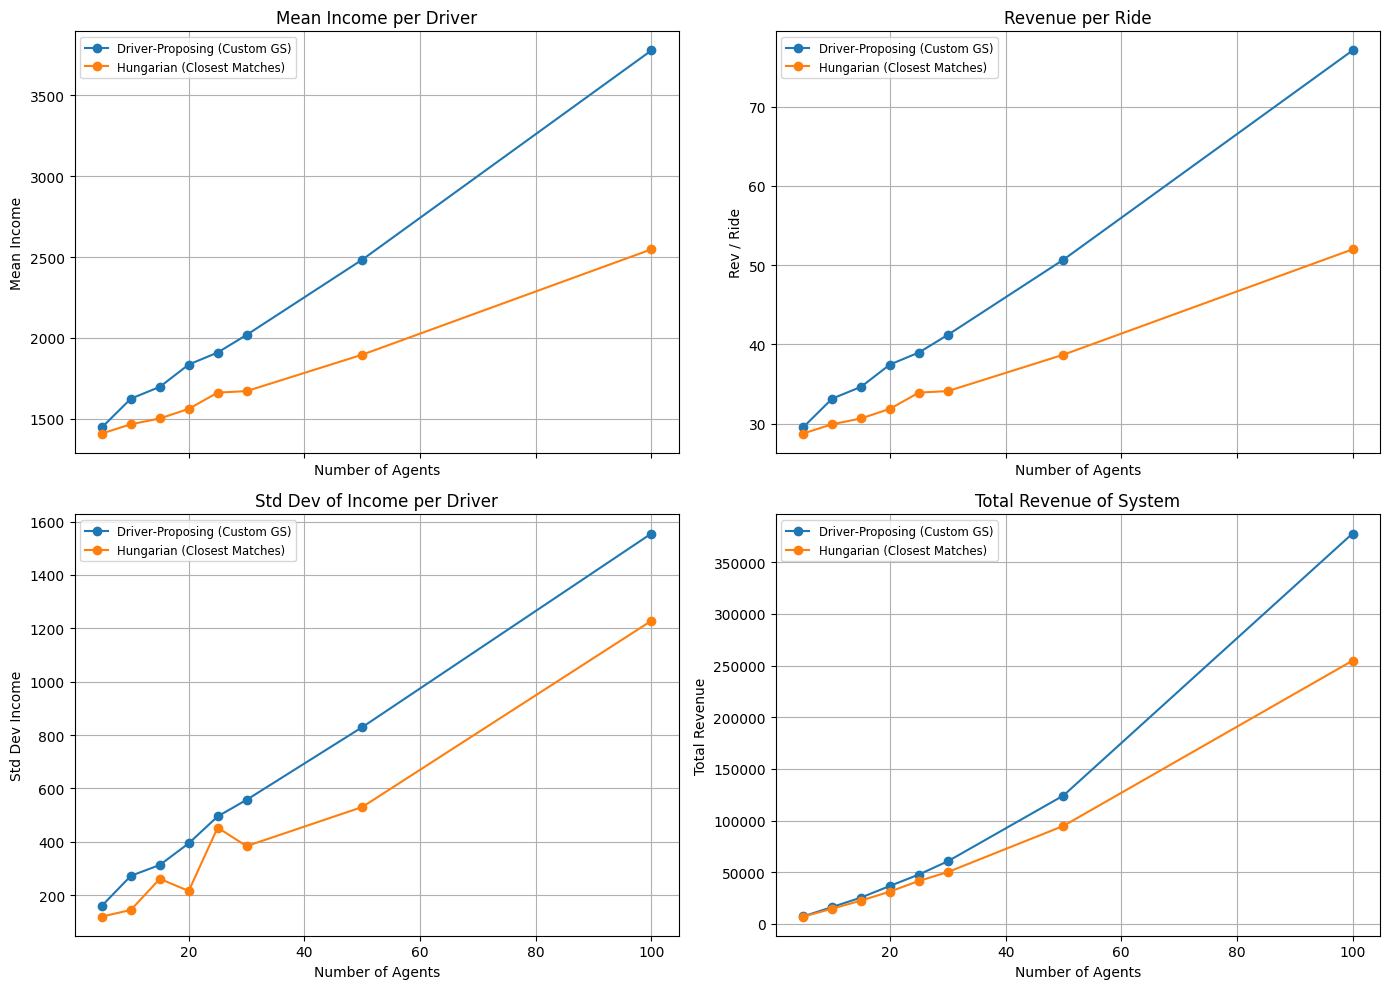

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) configure your sweep
agent_counts = [5, 10, 15, 20, 25, 30, 50, 100]    
algorithms = {
    "Driver‑Proposing (Custom GS)": driver_proposing_matching,
    "Hungarian (Closest Matches)":    closest_matches
}

# 2) run all simulations and collect results
records = []
for n in agent_counts:
    for name, func in algorithms.items():
        stats = simulations(df, n, {name: func})[name]
        records.append({
            "algorithm":      name,
            "num_agents":     n,
            "total_revenue":  stats["revenue"],
            "revenue_per_ride": stats["revenue_per_ride"],
            "mean_income":    stats["mean_income"],
            "sd_income":      stats["sd_income"],
            "jfi_income":     stats["jfi_income"],
            "gini_income":     stats["gini_income"]
        })

df_results = pd.DataFrame(records)

# 3) plot
fig, axs = plt.subplots(2, 2, figsize=(14,10), sharex=True)

for algo in df_results.algorithm.unique():
    sub = df_results[df_results.algorithm == algo]
    axs[0,0].plot(sub.num_agents, sub.mean_income,       marker='o', label=algo)
    axs[0,1].plot(sub.num_agents, sub.revenue_per_ride, marker='o', label=algo)
    axs[1,0].plot(sub.num_agents, sub.sd_income,         marker='o', label=algo)
    axs[1,1].plot(sub.num_agents, sub.total_revenue,    marker='o', label=algo)

# Titles and labels
axs[0,0].set(title="Mean Income per Driver",        xlabel="Number of Agents", ylabel="Mean Income")
axs[0,1].set(title="Revenue per Ride",              xlabel="Number of Agents", ylabel="Rev / Ride")
axs[1,0].set(title="Std Dev of Income per Driver",  xlabel="Number of Agents", ylabel="Std Dev Income")
axs[1,1].set(title="Total Revenue of System",       xlabel="Number of Agents", ylabel="Total Revenue")

for ax in axs.flatten():
    ax.grid(True)
    ax.legend(fontsize="small")

plt.tight_layout()
plt.show()